# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project


# Data Setup


## data download

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:

!unzip "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/train.zip" -d "/content/data2"


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/data2/train/e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/__MACOSX/train/._e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/train/8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/__MACOSX/train/._f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/train/3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/__MACOSX/train/._3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/train/e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content

## Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import pandas as pd
import os
import random

from PIL import Image


class CustomMultiLabelRotationDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, id_list=None):
        self.img_dir = img_dir
        self.transform = transform
        self.colors = ['red', 'green', 'blue', 'yellow']


        df = pd.read_csv(csv_path)
        self.id2label = {row['Id']: row['Target'] for _, row in df.iterrows()}


        all_ids_in_csv = set(self.id2label.keys())
        all_files = os.listdir(img_dir)
        all_ids_on_disk = set(
            fname.split('_')[0] for fname in all_files if fname.endswith('_red.png')
        )
        valid_ids = sorted(all_ids_in_csv & all_ids_on_disk)


        self.available_ids = sorted(set(id_list) & set(valid_ids)) if id_list else valid_ids

        all_labels = set()
        for label_str in self.id2label.values():
            labels = map(int, label_str.split())
            all_labels.update(labels)
        self.label_map = {label: i for i, label in enumerate(sorted(all_labels))}
        self.num_classes = len(self.label_map)

    def __len__(self):
        return len(self.available_ids)

    def __getitem__(self, idx):
        base_id = self.available_ids[idx]
        rotation_angle = random.choice([0, 90, 180, 270])

        channels = []
        for color in self.colors:
            path = os.path.join(self.img_dir, f"{base_id}_{color}.png")
            img = Image.open(path).convert('L')
            img = img.rotate(rotation_angle)
            channels.append(img)

        image = np.stack([np.array(ch) for ch in channels], axis=0)
        image = torch.from_numpy(image).float() / 255.0

        if self.transform:
            image = self.transform(image)

        multi_hot = torch.zeros(self.num_classes)
        for label in map(int, self.id2label[base_id].split()):
            multi_hot[self.label_map[label]] = 1

        return image, multi_hot

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    # transforms.ToTensor()
])

transform_val = transforms.Compose([
    # transforms.ToTensor()
])




In [ ]:
import os
import random
from sklearn.model_selection import train_test_split


img_dir = '/content/data2/train'
all_files = os.listdir(img_dir)
all_ids = sorted(set(
    fname.split('_')[0]
    for fname in all_files if fname.endswith('_red.png')
))


train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

train_dataset = CustomMultiLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_train,
    id_list=train_ids
)

val_dataset = CustomMultiLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_val,
    id_list=val_ids
)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

torch.Size([64, 28])


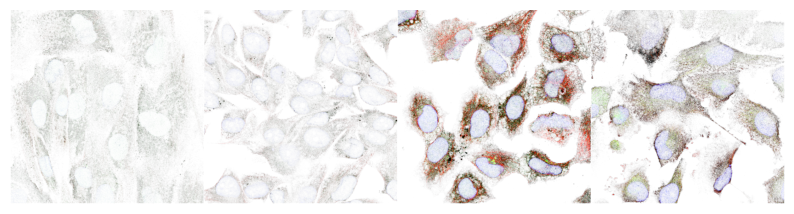

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np


for images, labels in train_loader:

    imgs = images[:4]
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    print(labels.shape)

    npimg = grid.numpy()
    plt.figure(figsize=(10, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # C, H, W → H, W, C
    plt.axis('off')
    plt.show()

    break


In [ ]:
# from PIL import Image
# Image.open('data2/train/7adf2db4-bb9b-11e8-b2b9-ac1f6b6435d0_red.png').show()

Show some example images and rotated images with labels:

# Evaluation code

In [ ]:
import time
import torch
from sklearn.metrics import f1_score

def run_test(net, testloader, criterion, threshold=0.5):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    net.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)  # (B, C)
            probs = torch.sigmoid(outputs)  # (B, C)
            preds = (probs > threshold).float()    # threshold

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())


            correct += (preds == labels).float().sum().item()
            total += labels.numel()  # B * C

            # loss
            avg_test_loss += criterion(outputs, labels).item()

    #  batch
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    #  macro F1
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    avg_test_loss = avg_test_loss / len(testloader)
    acc = 100 * correct / total

    print('TESTING:')
    print(f'Accuracy (per label bit): {acc:.2f} %')
    print(f'Average loss: {avg_test_loss:.4f}')
    print(f'f1: {macro_f1:.4f}')
    return acc / 100  # for compatibility


In [ ]:
def adjust_learning_rate(optimizer, epoch):
    if epoch > 40:
        lr = 1e-5
    elif epoch > 35:
        lr = 3e-5
    elif epoch > 30:
        lr = 7.5e-5
    elif epoch > 25:
        lr = 15e-5
    else:
        lr = 30e-5
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def adjust_learning_rate2(optimizer, epoch, init_lr, decay_epochs=15):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def save_checkpoint(model, optimizer, epoch, path='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"📦 Saved checkpoint at epoch {epoch}")

def load_checkpoint(model, optimizer, path='checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']


# Training

In [ ]:
from sklearn.metrics import f1_score
import time

def train(net, criterion, optimizer, num_epochs, init_lr, threshold=0.5, resume=False, ckpt_path='checkpoint.pth'):
    start_epoch = 0


    if resume:
        start_epoch = load_checkpoint(net, optimizer, path=ckpt_path)

    for epoch in range(start_epoch, num_epochs):
        # adjust_learning_rate(optimizer, epoch)
        adjust_learning_rate2(optimizer, epoch, init_lr)

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, labels) in enumerate(train_loader, 0):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            correct = (preds == labels).float().sum()
            total = torch.numel(labels)
            running_correct += correct.item()
            running_total += total
            running_loss += loss.item()

            macro_f1 = f1_score(labels.cpu(), preds.cpu(), average='macro', zero_division=0)

            if i % 100 == 99:
                acc = 100 * running_correct / running_total
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}, Acc: {acc:.2f}%, f1: {macro_f1:.2f} Time: {time.time() - start_time:.2f}s')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()


        net.eval()
        run_test(net, val_loader, criterion)


        save_checkpoint(net, optimizer, epoch + 1, path=ckpt_path)

    print('✅ Finished Training')


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn

## With facalloss

### resNet18


In [ ]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')  # multi-label

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets.float())
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)  # pt = p_t in paper
        focal_weight = (1 - pt) ** self.gamma
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(pretrained=True)
net.conv1 = nn.Conv2d(
    in_channels=4,
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)
net.fc = nn.Linear(in_features=512, out_features=28)
net = net.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = FocalLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

In [ ]:
train(net, criterion, optimizer, num_epochs=30, init_lr=0.001, resume=False)


[Epoch 1, Batch 100] Loss: 0.048, Acc: 93.86%, f1: 0.05 Time: 68.59s
[Epoch 1, Batch 200] Loss: 0.040, Acc: 94.97%, f1: 0.13 Time: 67.72s
[Epoch 1, Batch 300] Loss: 0.036, Acc: 95.37%, f1: 0.19 Time: 67.41s
[Epoch 1, Batch 400] Loss: 0.034, Acc: 95.60%, f1: 0.19 Time: 67.69s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.74 %
Average loss: 0.0348
f1: 0.1909
📦 Saved checkpoint at epoch 1
[Epoch 2, Batch 100] Loss: 0.032, Acc: 95.86%, f1: 0.18 Time: 68.14s
[Epoch 2, Batch 200] Loss: 0.031, Acc: 95.95%, f1: 0.30 Time: 67.10s
[Epoch 2, Batch 300] Loss: 0.030, Acc: 96.08%, f1: 0.29 Time: 66.84s
[Epoch 2, Batch 400] Loss: 0.030, Acc: 96.19%, f1: 0.23 Time: 66.98s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.50 %
Average loss: 0.0374
f1: 0.2698
📦 Saved checkpoint at epoch 2
[Epoch 3, Batch 100] Loss: 0.028, Acc: 96.27%, f1: 0.31 Time: 68.50s
[Epoch 3, Batch 200] Loss: 0.028, Acc: 96.33%, f1: 0.22 Time: 67.66s
[Epoch 3, Batch 300] Loss: 0.028, Acc: 96.40%, f1: 0.33 Time: 67.65s
[Epoch 3, Batch 400] Loss: 0.027, Acc: 96.42%, f1: 0.36 Time: 67.03s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.07 %
Average loss: 0.0295
f1: 0.3523
📦 Saved checkpoint at epoch 3
[Epoch 4, Batch 100] Loss: 0.026, Acc: 96.55%, f1: 0.45 Time: 68.38s
[Epoch 4, Batch 200] Loss: 0.026, Acc: 96.49%, f1: 0.26 Time: 68.19s
[Epoch 4, Batch 300] Loss: 0.026, Acc: 96.56%, f1: 0.38 Time: 68.33s
[Epoch 4, Batch 400] Loss: 0.027, Acc: 96.49%, f1: 0.34 Time: 68.33s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.46 %
Average loss: 0.0277
f1: 0.3877
📦 Saved checkpoint at epoch 4
[Epoch 5, Batch 100] Loss: 0.026, Acc: 96.57%, f1: 0.25 Time: 68.39s
[Epoch 5, Batch 200] Loss: 0.025, Acc: 96.60%, f1: 0.29 Time: 66.99s
[Epoch 5, Batch 300] Loss: 0.025, Acc: 96.66%, f1: 0.38 Time: 67.01s
[Epoch 5, Batch 400] Loss: 0.025, Acc: 96.64%, f1: 0.38 Time: 67.09s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.40 %
Average loss: 0.0274
f1: 0.3897
📦 Saved checkpoint at epoch 5
[Epoch 6, Batch 100] Loss: 0.024, Acc: 96.75%, f1: 0.37 Time: 68.83s
[Epoch 6, Batch 200] Loss: 0.024, Acc: 96.81%, f1: 0.41 Time: 67.66s
[Epoch 6, Batch 300] Loss: 0.024, Acc: 96.80%, f1: 0.46 Time: 68.16s
[Epoch 6, Batch 400] Loss: 0.024, Acc: 96.73%, f1: 0.32 Time: 66.99s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.69 %
Average loss: 0.0255
f1: 0.4082
📦 Saved checkpoint at epoch 6
[Epoch 7, Batch 100] Loss: 0.024, Acc: 96.78%, f1: 0.42 Time: 68.20s
[Epoch 7, Batch 200] Loss: 0.023, Acc: 96.92%, f1: 0.34 Time: 67.02s
[Epoch 7, Batch 300] Loss: 0.024, Acc: 96.84%, f1: 0.40 Time: 66.49s
[Epoch 7, Batch 400] Loss: 0.024, Acc: 96.83%, f1: 0.42 Time: 67.39s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.28 %
Average loss: 0.0288
f1: 0.3953
📦 Saved checkpoint at epoch 7
[Epoch 8, Batch 100] Loss: 0.023, Acc: 96.91%, f1: 0.41 Time: 67.97s
[Epoch 8, Batch 200] Loss: 0.023, Acc: 96.87%, f1: 0.34 Time: 68.24s
[Epoch 8, Batch 300] Loss: 0.023, Acc: 96.87%, f1: 0.49 Time: 67.46s
[Epoch 8, Batch 400] Loss: 0.023, Acc: 96.94%, f1: 0.36 Time: 67.85s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.88 %
Average loss: 0.0245
f1: 0.4339
📦 Saved checkpoint at epoch 8
[Epoch 9, Batch 100] Loss: 0.022, Acc: 96.94%, f1: 0.44 Time: 68.33s
[Epoch 9, Batch 200] Loss: 0.022, Acc: 96.97%, f1: 0.39 Time: 67.62s
[Epoch 9, Batch 300] Loss: 0.022, Acc: 97.00%, f1: 0.39 Time: 66.98s
[Epoch 9, Batch 400] Loss: 0.022, Acc: 97.00%, f1: 0.31 Time: 68.23s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.88 %
Average loss: 0.0234
f1: 0.5140
📦 Saved checkpoint at epoch 9
[Epoch 10, Batch 100] Loss: 0.022, Acc: 97.09%, f1: 0.46 Time: 68.02s
[Epoch 10, Batch 200] Loss: 0.022, Acc: 97.02%, f1: 0.38 Time: 66.70s
[Epoch 10, Batch 300] Loss: 0.022, Acc: 97.04%, f1: 0.40 Time: 67.27s
[Epoch 10, Batch 400] Loss: 0.022, Acc: 97.03%, f1: 0.48 Time: 66.96s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.89 %
Average loss: 0.0234
f1: 0.5031
📦 Saved checkpoint at epoch 10
[Epoch 11, Batch 100] Loss: 0.021, Acc: 97.11%, f1: 0.35 Time: 68.46s
[Epoch 11, Batch 200] Loss: 0.021, Acc: 97.07%, f1: 0.42 Time: 68.57s
[Epoch 11, Batch 300] Loss: 0.021, Acc: 97.08%, f1: 0.49 Time: 67.54s
[Epoch 11, Batch 400] Loss: 0.021, Acc: 97.11%, f1: 0.41 Time: 68.73s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.90 %
Average loss: 0.0231
f1: 0.5177
📦 Saved checkpoint at epoch 11
[Epoch 12, Batch 100] Loss: 0.021, Acc: 97.06%, f1: 0.39 Time: 68.54s
[Epoch 12, Batch 200] Loss: 0.021, Acc: 97.14%, f1: 0.55 Time: 67.79s
[Epoch 12, Batch 300] Loss: 0.021, Acc: 97.12%, f1: 0.46 Time: 68.04s
[Epoch 12, Batch 400] Loss: 0.021, Acc: 97.10%, f1: 0.52 Time: 68.68s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.00 %
Average loss: 0.0223
f1: 0.4812
📦 Saved checkpoint at epoch 12
[Epoch 13, Batch 100] Loss: 0.020, Acc: 97.19%, f1: 0.42 Time: 69.58s
[Epoch 13, Batch 200] Loss: 0.020, Acc: 97.24%, f1: 0.42 Time: 68.67s
[Epoch 13, Batch 300] Loss: 0.020, Acc: 97.18%, f1: 0.45 Time: 68.66s
[Epoch 13, Batch 400] Loss: 0.020, Acc: 97.23%, f1: 0.35 Time: 67.62s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.86 %
Average loss: 0.0235
f1: 0.5208
📦 Saved checkpoint at epoch 13
[Epoch 14, Batch 100] Loss: 0.019, Acc: 97.30%, f1: 0.42 Time: 67.75s
[Epoch 14, Batch 200] Loss: 0.020, Acc: 97.28%, f1: 0.32 Time: 67.56s
[Epoch 14, Batch 300] Loss: 0.020, Acc: 97.27%, f1: 0.46 Time: 68.00s
[Epoch 14, Batch 400] Loss: 0.020, Acc: 97.17%, f1: 0.45 Time: 67.69s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.01 %
Average loss: 0.0224
f1: 0.5260
📦 Saved checkpoint at epoch 14
[Epoch 15, Batch 100] Loss: 0.019, Acc: 97.34%, f1: 0.48 Time: 68.05s
[Epoch 15, Batch 200] Loss: 0.019, Acc: 97.36%, f1: 0.51 Time: 67.45s
[Epoch 15, Batch 300] Loss: 0.020, Acc: 97.29%, f1: 0.47 Time: 67.86s
[Epoch 15, Batch 400] Loss: 0.019, Acc: 97.30%, f1: 0.43 Time: 66.88s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.24 %
Average loss: 0.0215
f1: 0.5318
📦 Saved checkpoint at epoch 15
[Epoch 16, Batch 100] Loss: 0.017, Acc: 97.57%, f1: 0.48 Time: 68.05s
[Epoch 16, Batch 200] Loss: 0.016, Acc: 97.73%, f1: 0.65 Time: 67.83s
[Epoch 16, Batch 300] Loss: 0.016, Acc: 97.74%, f1: 0.46 Time: 67.15s
[Epoch 16, Batch 400] Loss: 0.016, Acc: 97.76%, f1: 0.44 Time: 67.74s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.47 %
Average loss: 0.0191
f1: 0.6025
📦 Saved checkpoint at epoch 16
[Epoch 17, Batch 100] Loss: 0.015, Acc: 97.80%, f1: 0.49 Time: 68.49s
[Epoch 17, Batch 200] Loss: 0.015, Acc: 97.81%, f1: 0.44 Time: 67.88s
[Epoch 17, Batch 300] Loss: 0.016, Acc: 97.74%, f1: 0.56 Time: 68.21s
[Epoch 17, Batch 400] Loss: 0.015, Acc: 97.77%, f1: 0.53 Time: 68.60s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.51 %
Average loss: 0.0193
f1: 0.6036
📦 Saved checkpoint at epoch 17
[Epoch 18, Batch 100] Loss: 0.015, Acc: 97.89%, f1: 0.57 Time: 68.94s
[Epoch 18, Batch 200] Loss: 0.015, Acc: 97.82%, f1: 0.44 Time: 67.10s
[Epoch 18, Batch 300] Loss: 0.015, Acc: 97.88%, f1: 0.52 Time: 67.94s
[Epoch 18, Batch 400] Loss: 0.015, Acc: 97.84%, f1: 0.43 Time: 67.92s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.56 %
Average loss: 0.0188
f1: 0.6090
📦 Saved checkpoint at epoch 18
[Epoch 19, Batch 100] Loss: 0.015, Acc: 97.85%, f1: 0.51 Time: 69.68s
[Epoch 19, Batch 200] Loss: 0.015, Acc: 97.90%, f1: 0.60 Time: 68.42s
[Epoch 19, Batch 300] Loss: 0.015, Acc: 97.87%, f1: 0.59 Time: 68.90s
[Epoch 19, Batch 400] Loss: 0.014, Acc: 97.93%, f1: 0.44 Time: 69.06s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.53 %
Average loss: 0.0191
f1: 0.6198
📦 Saved checkpoint at epoch 19
[Epoch 20, Batch 100] Loss: 0.014, Acc: 97.91%, f1: 0.54 Time: 69.11s
[Epoch 20, Batch 200] Loss: 0.014, Acc: 97.97%, f1: 0.57 Time: 68.39s
[Epoch 20, Batch 300] Loss: 0.014, Acc: 97.92%, f1: 0.55 Time: 67.92s
[Epoch 20, Batch 400] Loss: 0.014, Acc: 97.90%, f1: 0.47 Time: 67.88s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.54 %
Average loss: 0.0192
f1: 0.6398
📦 Saved checkpoint at epoch 20
[Epoch 21, Batch 100] Loss: 0.014, Acc: 97.98%, f1: 0.51 Time: 69.50s
[Epoch 21, Batch 200] Loss: 0.014, Acc: 97.97%, f1: 0.50 Time: 68.09s
[Epoch 21, Batch 300] Loss: 0.013, Acc: 98.02%, f1: 0.51 Time: 67.77s
[Epoch 21, Batch 400] Loss: 0.014, Acc: 97.92%, f1: 0.71 Time: 68.93s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.54 %
Average loss: 0.0192
f1: 0.6307
📦 Saved checkpoint at epoch 21
[Epoch 22, Batch 100] Loss: 0.013, Acc: 98.04%, f1: 0.50 Time: 68.50s
[Epoch 22, Batch 200] Loss: 0.014, Acc: 97.97%, f1: 0.52 Time: 67.10s
[Epoch 22, Batch 300] Loss: 0.014, Acc: 98.00%, f1: 0.44 Time: 67.69s
[Epoch 22, Batch 400] Loss: 0.014, Acc: 98.04%, f1: 0.45 Time: 67.93s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.55 %
Average loss: 0.0195
f1: 0.6209
📦 Saved checkpoint at epoch 22
[Epoch 23, Batch 100] Loss: 0.013, Acc: 98.04%, f1: 0.55 Time: 68.47s
[Epoch 23, Batch 200] Loss: 0.013, Acc: 98.04%, f1: 0.47 Time: 67.58s
[Epoch 23, Batch 300] Loss: 0.013, Acc: 98.01%, f1: 0.62 Time: 67.61s
[Epoch 23, Batch 400] Loss: 0.013, Acc: 98.02%, f1: 0.44 Time: 67.65s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.54 %
Average loss: 0.0196
f1: 0.6100
📦 Saved checkpoint at epoch 23
[Epoch 24, Batch 100] Loss: 0.013, Acc: 98.06%, f1: 0.55 Time: 68.54s
[Epoch 24, Batch 200] Loss: 0.012, Acc: 98.13%, f1: 0.53 Time: 67.51s
[Epoch 24, Batch 300] Loss: 0.013, Acc: 98.09%, f1: 0.57 Time: 67.36s
[Epoch 24, Batch 400] Loss: 0.013, Acc: 98.05%, f1: 0.48 Time: 66.50s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.56 %
Average loss: 0.0195
f1: 0.6290
📦 Saved checkpoint at epoch 24
[Epoch 25, Batch 100] Loss: 0.012, Acc: 98.17%, f1: 0.53 Time: 67.11s
[Epoch 25, Batch 200] Loss: 0.013, Acc: 98.08%, f1: 0.51 Time: 66.38s
[Epoch 25, Batch 300] Loss: 0.013, Acc: 98.11%, f1: 0.70 Time: 66.74s
[Epoch 25, Batch 400] Loss: 0.013, Acc: 98.09%, f1: 0.52 Time: 65.95s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.51 %
Average loss: 0.0197
f1: 0.6164
📦 Saved checkpoint at epoch 25
[Epoch 26, Batch 100] Loss: 0.012, Acc: 98.17%, f1: 0.54 Time: 67.20s
[Epoch 26, Batch 200] Loss: 0.013, Acc: 98.13%, f1: 0.45 Time: 66.60s
[Epoch 26, Batch 300] Loss: 0.013, Acc: 98.07%, f1: 0.57 Time: 66.63s
[Epoch 26, Batch 400] Loss: 0.012, Acc: 98.13%, f1: 0.60 Time: 67.16s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.54 %
Average loss: 0.0203
f1: 0.6231
📦 Saved checkpoint at epoch 26
[Epoch 27, Batch 100] Loss: 0.012, Acc: 98.15%, f1: 0.51 Time: 67.88s
[Epoch 27, Batch 200] Loss: 0.012, Acc: 98.16%, f1: 0.59 Time: 66.96s
[Epoch 27, Batch 300] Loss: 0.012, Acc: 98.17%, f1: 0.53 Time: 65.77s
[Epoch 27, Batch 400] Loss: 0.012, Acc: 98.19%, f1: 0.53 Time: 65.97s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.58 %
Average loss: 0.0202
f1: 0.6293
📦 Saved checkpoint at epoch 27
[Epoch 28, Batch 100] Loss: 0.012, Acc: 98.23%, f1: 0.56 Time: 69.24s
[Epoch 28, Batch 200] Loss: 0.012, Acc: 98.23%, f1: 0.51 Time: 67.66s
[Epoch 28, Batch 300] Loss: 0.012, Acc: 98.19%, f1: 0.59 Time: 66.30s
[Epoch 28, Batch 400] Loss: 0.012, Acc: 98.24%, f1: 0.59 Time: 68.06s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.53 %
Average loss: 0.0205
f1: 0.6376
📦 Saved checkpoint at epoch 28
[Epoch 29, Batch 100] Loss: 0.011, Acc: 98.27%, f1: 0.72 Time: 68.11s
[Epoch 29, Batch 200] Loss: 0.012, Acc: 98.23%, f1: 0.48 Time: 67.27s
[Epoch 29, Batch 300] Loss: 0.012, Acc: 98.23%, f1: 0.59 Time: 67.11s
[Epoch 29, Batch 400] Loss: 0.011, Acc: 98.29%, f1: 0.59 Time: 66.33s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.47 %
Average loss: 0.0210
f1: 0.6318
📦 Saved checkpoint at epoch 29
[Epoch 30, Batch 100] Loss: 0.011, Acc: 98.33%, f1: 0.64 Time: 68.04s
[Epoch 30, Batch 200] Loss: 0.011, Acc: 98.28%, f1: 0.64 Time: 66.74s
[Epoch 30, Batch 300] Loss: 0.011, Acc: 98.28%, f1: 0.56 Time: 67.49s
[Epoch 30, Batch 400] Loss: 0.012, Acc: 98.26%, f1: 0.54 Time: 67.51s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 97.46 %
Average loss: 0.0211
f1: 0.6327
📦 Saved checkpoint at epoch 30
✅ Finished Training


In [ ]:
torch.save(net, 'model_resnet18_focalLoss_epoch30.pth')